In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from bisect import bisect


<h1>Import Results From Spreadsheet


<h3> This imports columns of data as a dict of lists with keys 'Sheet Name - Column Header'

In [2]:
def import_ods(file_path):
    """
    Import all sheets from ODS file and return a dictionary with column data
    
    Args:
        file_path (str): Path to the ODS file
    
    Returns:
        dict: Dictionary with keys 'Sheet Name - Column Header' and values as column arrays
              Returns None if error occurs
    """
    try:
        # Check if file exists
        if not os.path.exists(file_path):
            print(f"Error: File '{file_path}' not found.")
            return None
        
        # Import all sheets from the ODS file
        all_sheets = pd.read_excel(file_path, sheet_name=None, engine='odf')
        
        # Initialize result dictionary
        result_dict = {}
        
        # Process each sheet
        for sheet_name, df in all_sheets.items():
            print(f"Processing sheet: '{sheet_name}'")
            print(f"  Shape: {df.shape} (rows, columns)")
            
            # Find the maximum length (number of rows) in this sheet
            max_length = len(df)
            
            # Process each column in the sheet
            for column_header in df.columns:
                # Create the key with format 'Sheet Name - Column Header'
                key = f"{sheet_name} - {column_header}"
                
                # Get the column data, replacing NaN with None
                column_data = df[column_header].where(df[column_header].notna(), None).values
                
                # Ensure all arrays have the same length (should already be the case with pandas)
                # But this makes it explicit
                if len(column_data) < max_length:
                    # Pad with None values if somehow shorter
                    column_data = list(column_data) + [None] * (max_length - len(column_data))
                
                # Store in result dictionary
                result_dict[key] = column_data
                
                # Count non-None values for reporting
                non_none_count = sum(1 for x in column_data if x is not None)
                #print(f"    Column '{column_header}': {non_none_count}/{len(column_data)} non-empty values")
        
        #print(f"\nSuccessfully imported {len(all_sheets)} sheets from '{file_path}'")
        #print(f"Total columns across all sheets: {len(result_dict)}")
        
        return result_dict
        
    except pd.errors.EmptyDataError:
        print(f"Error: '{file_path}' is empty.")
        return None
    except Exception as e:
        print(f"Error reading ODS file: {e}")
        print("Make sure you have the 'odfpy' package installed: pip install odfpy")
        return None
    

data = import_ods('FSAE Michigan 2025 Results.ods')

Processing sheet: 'Overall'
  Shape: (101, 13) (rows, columns)
Processing sheet: 'Design'
  Shape: (101, 8) (rows, columns)
Processing sheet: 'Presentation'
  Shape: (101, 6) (rows, columns)
Processing sheet: 'Cost'
  Shape: (101, 10) (rows, columns)
Processing sheet: 'Acceleration'
  Shape: (101, 18) (rows, columns)
Processing sheet: 'Skidpad'
  Shape: (101, 22) (rows, columns)
Processing sheet: 'AutoX'
  Shape: (101, 22) (rows, columns)
Processing sheet: 'Endurance'
  Shape: (30, 11) (rows, columns)
Processing sheet: 'Efficiency'
  Shape: (22, 11) (rows, columns)
Processing sheet: 'Endurance Lap Times'
  Shape: (30, 25) (rows, columns)
Processing sheet: 'Team Info'
  Shape: (101, 7) (rows, columns)


<h2>Dynamic Event Analysis

<h3> Prepares time and score data for each dynamic event

In [8]:
#ACCELERATION
acc_times = data['Acceleration - Best Time']
acc_scores = data['Acceleration - Score']

ta_min = np.nanmin(acc_times)
ta_max = 1.5*ta_min

def comp_acc_score(time):
    time = np.asarray(time)
    return [np.max([(95.5*((ta_max/t)-1)/((ta_max/ta_min)-1)) + 4.5, 4.5]) for t in time]

acc_trange = np.linspace(ta_min, np.nanmax(acc_times))


#SKIDPAD
skidpad_times = data['Skidpad - Best Time']
skidpad_scores = data['Skidpad - Score']

tsp_min = np.nanmin(skidpad_times)
tsp_max = 1.25*tsp_min

def comp_skidpad_score(time):
    time = np.asarray(time)
    return [np.max([71.5*((tsp_max/t)**2 - 1)/((tsp_max/tsp_min)**2 - 1) + 3.5, 3.5]) for t in time]

skidpad_trange = np.linspace(tsp_min, np.nanmax(skidpad_times))



#AUTOX
autox_times = data['AutoX - Best Time']
autox_scores = data['AutoX - Score']

tax_min = np.nanmin(autox_times)
tax_max = 1.45*tax_min

def comp_autox_score(time):
    time = np.asarray(time)
    return [np.max([118.5*((tax_max/t) - 1)/((tax_max/tax_min) - 1) + 6.5, 6.5]) for t in time]

autox_trange = np.linspace(tax_min, np.nanmax(autox_times))



#ENDURANCE
end_times = data['Endurance - Adjusted Time']
end_scores = data['Endurance - Time Score'][0:len(end_times)]

#Removes values which did not complete endurance and register a total time
not_nan_mask = ~np.isnan(end_times)
    
# Apply the mask to both arrays
end_times = end_times[not_nan_mask]
end_scores = end_scores[not_nan_mask]

tend_min = np.nanmin(end_times)
tend_max = 1.45*tend_min

def comp_end_score(time):
    time = np.asarray(time)
    return [np.max([250*((tend_max/t) - 1)/((tend_max/tend_min) - 1),0]) for t in time]


end_trange = np.linspace(tend_min, np.nanmax(end_times))

<h1>Dynamic Event Plotting 

<h3>Plots Score vs Time for each dynamic event

Text(0, 0.5, 'Time Score')

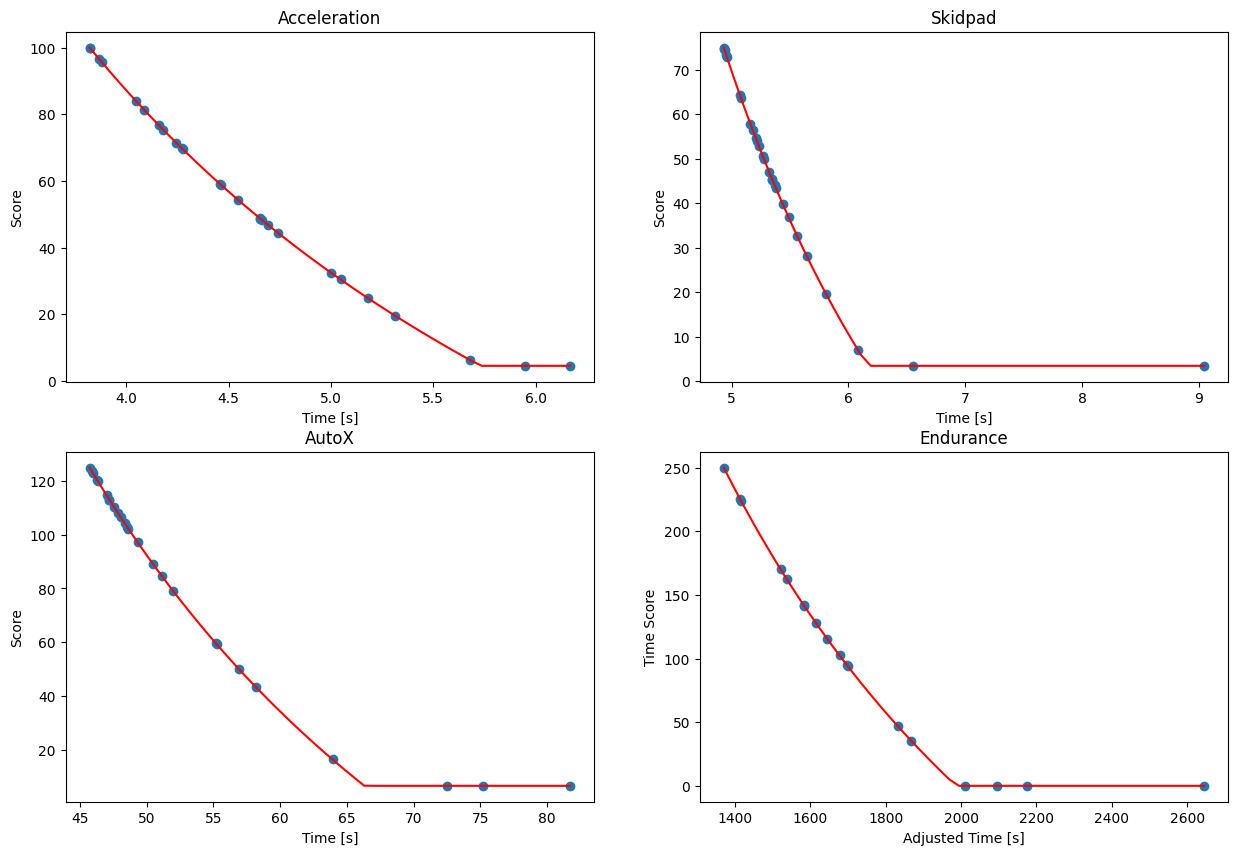

In [4]:
fig, axes = plt.subplots(2,2, figsize=(15, 10))

acceleration_graph = axes[0,0]
acceleration_graph.scatter(acc_times, acc_scores)
acceleration_graph.plot(acc_trange, comp_acc_score(acc_trange), 'r')
acceleration_graph.set_title('Acceleration')
acceleration_graph.set_xlabel('Time [s]')
acceleration_graph.set_ylabel('Score')

skidpad_graph = axes[0,1]
skidpad_graph.scatter(skidpad_times, skidpad_scores)
skidpad_graph.plot(skidpad_trange, comp_skidpad_score(skidpad_trange), 'r')
skidpad_graph.set_title('Skidpad')
skidpad_graph.set_xlabel('Time [s]')
skidpad_graph.set_ylabel('Score')

autox_graph = axes[1,0]
autox_graph.scatter(autox_times, autox_scores)
autox_graph.plot(autox_trange, comp_autox_score(autox_trange), 'r')
autox_graph.set_title('AutoX')
autox_graph.set_xlabel('Time [s]')
autox_graph.set_ylabel('Score')

endurance_graph = axes[1,1]
endurance_graph.scatter(end_times, end_scores)
endurance_graph.plot(end_trange, comp_end_score(end_trange), 'r')
endurance_graph.set_title('Endurance')
endurance_graph.set_xlabel('Adjusted Time [s]')
endurance_graph.set_ylabel('Time Score')



<h1>Competition outcome by percentile</h1>


<h3>This predicts the score generated and the final placement of a car that completes all dynamic events at a specific percentile of time
Static event scores are excluded</h3>

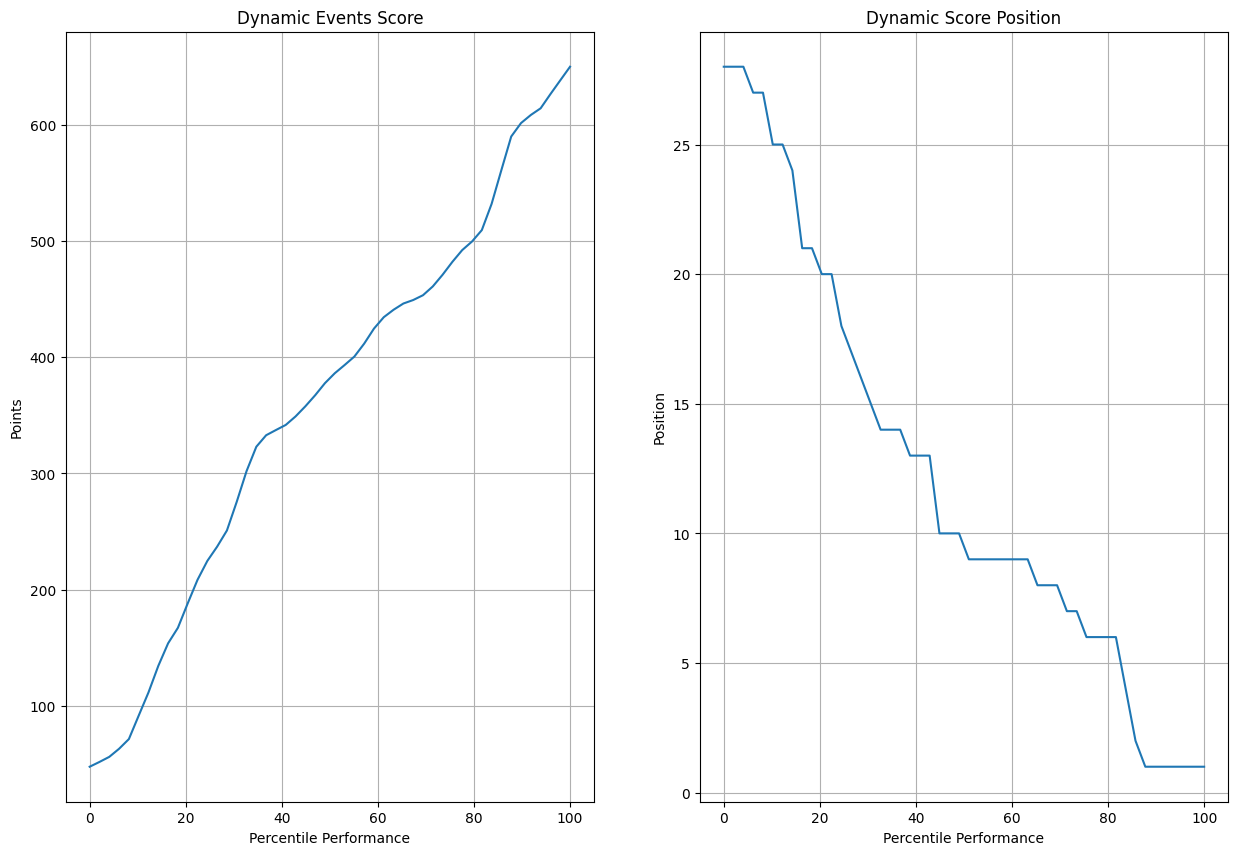

In [24]:
def interpolate_percentile(x_data, y_data, percentile):
    """
    Returns the linearly interpolated y-value at the given percentile of x_data.
    
    Parameters:
    x_data (array-like): X coordinates (must be sortable)
    y_data (array-like): Y coordinates corresponding to x_data
    percentile (float): Percentile value between 0 and 100
    
    Returns:
    float: Interpolated y-value at the specified percentile
    
    Raises:
    ValueError: If percentile is not between 0 and 100, or if arrays have different lengths
    """
    
    # Input validation
    if not (0 <= percentile <= 100):
        raise ValueError("Percentile must be between 0 and 100")
    
    x_data = np.array(x_data[~np.isnan(x_data)])
    y_data = np.array(y_data[~np.isnan(y_data)])
    
    if len(x_data) != len(y_data):
        raise ValueError("x_data and y_data must have the same length")
    
    if len(x_data) == 0:
        raise ValueError("Input arrays cannot be empty")
    
    # Sort data by x values
    sorted_indices = np.argsort(x_data)
    x_sorted = x_data[sorted_indices]
    y_sorted = y_data[sorted_indices]
    
    # Calculate the target x value at the given percentile
    target_x = np.percentile(x_sorted, percentile)
    
    # Handle edge cases
    if target_x <= x_sorted[0]:
        return y_sorted[0]
    if target_x >= x_sorted[-1]:
        return y_sorted[-1]
    
    # Find the two points to interpolate between
    # Find the index where target_x would be inserted to keep array sorted
    insert_idx = np.searchsorted(x_sorted, target_x)
    
    # Get the surrounding points
    x1, x2 = x_sorted[insert_idx-1], x_sorted[insert_idx]
    y1, y2 = y_sorted[insert_idx-1], y_sorted[insert_idx]
    
    # Linear interpolation
    interpolated_y = y1 + (target_x - x1) * (y2 - y1) / (x2 - x1)
    
    return interpolated_y

def zero_nan(data):
    data[np.isnan(data)] = 0
    return data


eff_factor = data['Efficiency - Efficiency Factor']
eff_scores = data['Efficiency - Efficiency Score']

mask = ~np.isnan(eff_factor)
eff_factor = eff_factor[mask]
eff_scores = eff_scores[mask]



performance = [-1*acc_times, -1*skidpad_times, -1*autox_times, -1*end_times, eff_factor]
points = [acc_scores, skidpad_scores, autox_scores, end_scores, eff_scores]


def total_score_by_percentile(p):
    output=0
    for perf,pts in zip(performance, points):
        output += interpolate_percentile(perf, pts, p) 

    return output


percs = np.linspace(0,100)

fig, axes = plt.subplots(1,2, figsize=(15, 10))

axes[0].plot(percs, [total_score_by_percentile(p) for p in percs])
axes[0].set_xlabel('Percentile Performance')
axes[0].set_ylabel('Points')
axes[0].set_title('Dynamic Events Score')
axes[0].grid()



dynamic_scores = zero_nan(data['Overall - Acceleration Score']) + zero_nan(data['Overall - Skid Pad Score']) + zero_nan(data['Overall - Autocross Score']) + zero_nan(data['Overall - Endurance Score']) + zero_nan(data['Overall - Efficiency Score'])
dynamic_scores = np.sort(dynamic_scores)[::-1]

def find_place(all_scores, my_score):
    for i, score in enumerate(all_scores):
        if my_score>score:
            return i+1
    return len(all_scores)

axes[1].plot(percs, [find_place(dynamic_scores, total_score_by_percentile(p)) for p in percs])
axes[1].set_xlabel('Percentile Performance')
axes[1].set_ylabel('Position')
axes[1].set_title('Dynamic Score Position')
axes[1].grid()



<h1>Mass-Performance Analysis</h1>

Text(0, 0.5, 'Score')

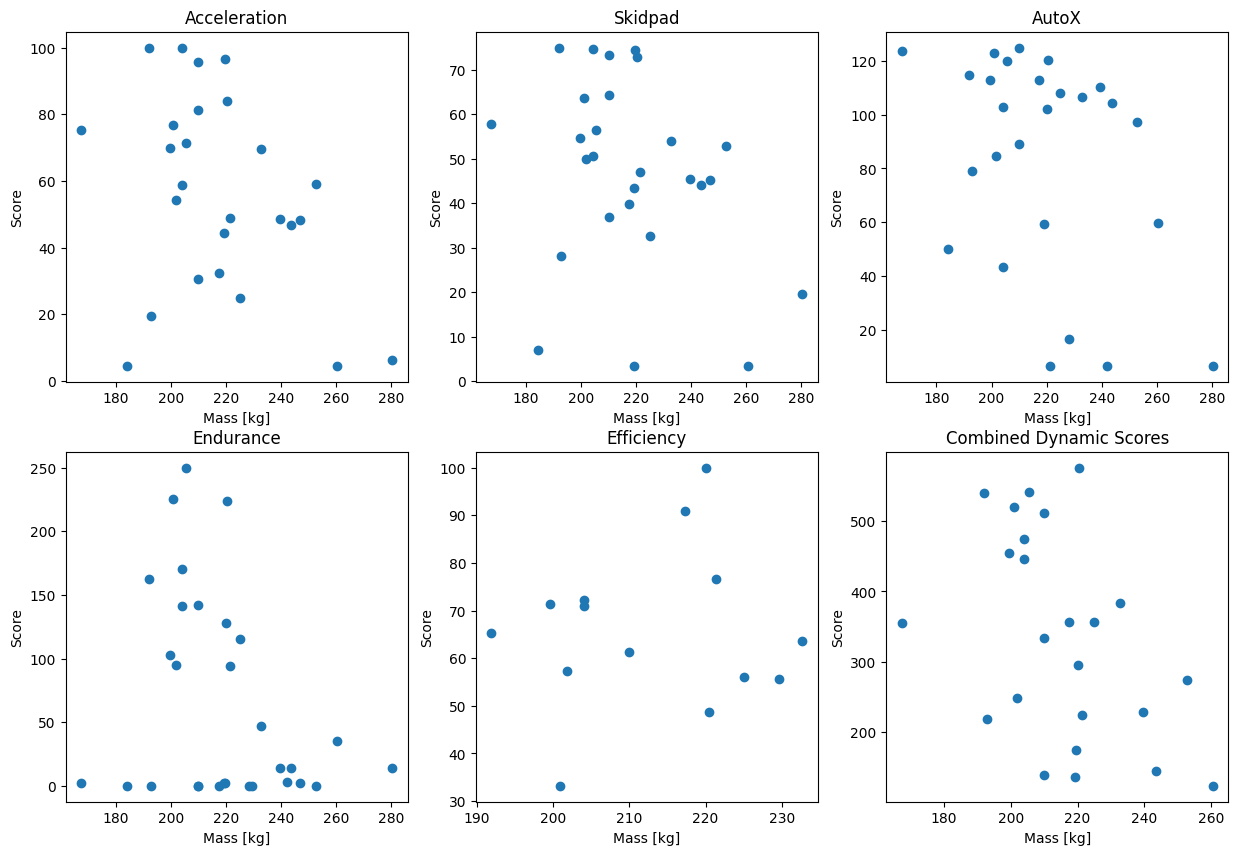

In [39]:
def indices_of_a_in_b(data_a, data_b):
    """
    Find indices where each element of data_a appears in data_b.
    
    Parameters:
    -----------
    data_a : array-like
        Values to search for
    data_b : array-like  
        Array to search in
    
    Returns:
    --------
    list : List of indices where each data_a element appears in data_b
           Returns np.nan if element is not found
    """
    data_a = data_a[~np.isnan(data_a)]
    return [np.where(data_b == data_point)[0][0] for data_point in data_a]


fig, axes = plt.subplots(2,3, figsize=(15, 10))

info_carnums = data['Team Info - Car Num']
info_masses = data['Team Info - Weight (kg)']


#Uses car numbers to associates mass from car Team Info sheet with acceleration data
acceleration_masses = info_masses[indices_of_a_in_b(data['Acceleration - Car Num'], info_carnums)]
acceleration_graph = axes[0,0]
acceleration_graph.scatter(acceleration_masses, acc_scores)
acceleration_graph.set_title('Acceleration')
acceleration_graph.set_xlabel('Mass [kg]')
acceleration_graph.set_ylabel('Score')

skidpad_masses = info_masses[indices_of_a_in_b(data['Acceleration - Car Num'], info_carnums)]
skidpad_graph = axes[0,1]
skidpad_graph.scatter(skidpad_masses, skidpad_scores)
skidpad_graph.set_title('Skidpad')
skidpad_graph.set_xlabel('Mass [kg]')
skidpad_graph.set_ylabel('Score')

autox_masses = info_masses[indices_of_a_in_b(data['AutoX - Car Num'], info_carnums)]
autox_graph = axes[0,2]
autox_graph.scatter(autox_masses, autox_scores)
autox_graph.set_title('AutoX')
autox_graph.set_xlabel('Mass [kg]')
autox_graph.set_ylabel('Score')

endurance_masses = info_masses[indices_of_a_in_b(data['Endurance - Car Num'], info_carnums)]
endurance_graph = axes[1,0]
endurance_graph.scatter(endurance_masses, data['Endurance - Time Score'])
endurance_graph.set_title('Endurance')
endurance_graph.set_xlabel('Mass [kg]')
endurance_graph.set_ylabel('Score')

efficiency_masses = info_masses[indices_of_a_in_b(data['Efficiency - Car Num'], info_carnums)]
efficiency_graph = axes[1,1]
efficiency_graph.scatter(efficiency_masses, data['Efficiency - Efficiency Score'])
efficiency_graph.set_title('Efficiency')
efficiency_graph.set_xlabel('Mass [kg]')
efficiency_graph.set_ylabel('Score')


ovr_sorted_masses = info_masses[indices_of_a_in_b(data['Overall - Car Num'], info_carnums)]
masses_for_nonzero_scores, nonzero_dynamic_scores = map(list, zip(*[(mass, score) for (mass, score) in zip(ovr_sorted_masses, dynamic_scores) if score>100 ]))
overall_graph = axes[1,2]
overall_graph.set_title('Combined Dynamic Scores')
overall_graph.scatter(masses_for_nonzero_scores, nonzero_dynamic_scores)
overall_graph.set_xlabel('Mass [kg]')
overall_graph.set_ylabel('Score')


<h1>Skidpad Lateral Acceleration</h1>

8.225


Text(0, 0.5, 'Score')

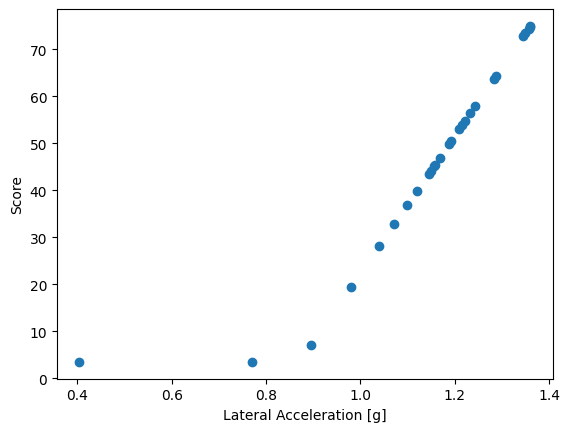

In [7]:
diameter = 15.25
track_width = 1.2
turn_radius = (diameter + track_width)/2

print(turn_radius)

def avg_lateral_skidpad_acceleration(time, r=turn_radius):
    distance_covered = 2*np.pi*turn_radius
    avg_speed = distance_covered/time
    return avg_speed**2 / r / 9.81

plt.scatter(avg_lateral_skidpad_acceleration(skidpad_times), skidpad_scores)
plt.xlabel('Lateral Acceleration [g]')
plt.ylabel('Score')


